# Setup

In [1]:
# To support both python 2 and python 3
from __future__ import division, print_function, unicode_literals

# Common imports
import numpy as np
import pandas as pd
import os

# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Where to save the figures
PROJECT_ROOT_DIR = "../"
CHAPTER_ID = "classification"

def save_fig(fig_id, tight_layout=True):
    path = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID, fig_id + ".png")
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format='png', dpi=300)

# MNIST

**Warning**: `fetch_mldata()` is deprecated since Scikit-Learn 0.20. You should use `fetch_openml()` instead. However, it returns the unsorted MNIST dataset, whereas `fetch_mldata()` returned the dataset sorted by target (the training set and the test test were sorted separately). In general, this is fine, but if you want to get the exact same results as before, you need to sort the dataset using the following function:

In [2]:
d = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(name=d, exist_ok=True)

In [3]:
def sort_by_target(mnist):
    reorder_train = np.array(sorted([(target, i) for i, target in enumerate(mnist.target[:60000])]))[:, 1]
    reorder_test = np.array(sorted([(target, i) for i, target in enumerate(mnist.target[60000:])]))[:, 1]
    mnist.data[:60000] = mnist.data[reorder_train]
    mnist.target[:60000] = mnist.target[reorder_train]
    mnist.data[60000:] = mnist.data[reorder_test + 60000]
    mnist.target[60000:] = mnist.target[reorder_test + 60000]

In [4]:
try:
    from sklearn.datasets import fetch_openml
    mnist = fetch_openml('mnist_784', version=1, cache=True)
    mnist.target = mnist.target.astype(np.int8) # fetch_openml() returns targets as strings
    sort_by_target(mnist) # fetch_openml() returns an unsorted dataset
except ImportError:
    from sklearn.datasets import fetch_mldata
    mnist = fetch_mldata('MNIST original')
mnist["data"], mnist["target"]

(array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]),
 array([0, 0, 0, ..., 9, 9, 9], dtype=int8))

In [5]:
type(mnist)

sklearn.utils.Bunch

In [6]:
mnist.keys()

dict_keys(['data', 'target', 'feature_names', 'DESCR', 'details', 'categories', 'url'])

In [7]:
mnist.data.shape

(70000, 784)

In [8]:
X, y = mnist["data"], mnist["target"]
X.shape

(70000, 784)

In [9]:
y.shape

(70000,)

In [10]:
28*28

784

In [11]:
type(X[0])

numpy.ndarray

In [12]:
X[0].shape

(784,)

Saving figure some_digit_plot


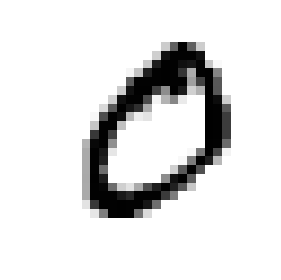

Saving figure some_digit_plot


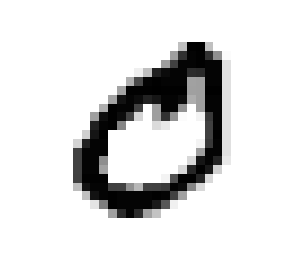

Saving figure some_digit_plot


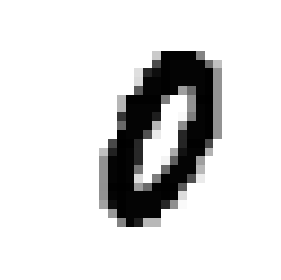

Saving figure some_digit_plot


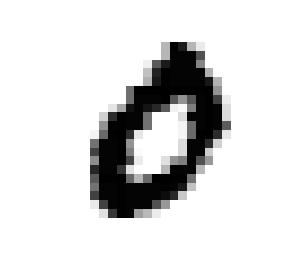

Saving figure some_digit_plot


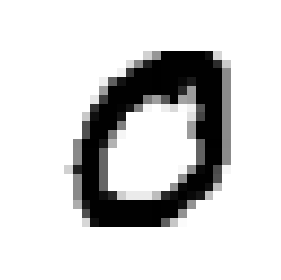

Saving figure some_digit_plot


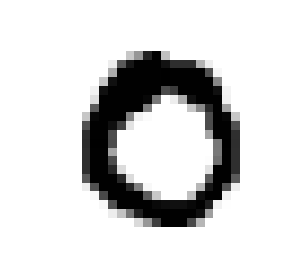

Saving figure some_digit_plot


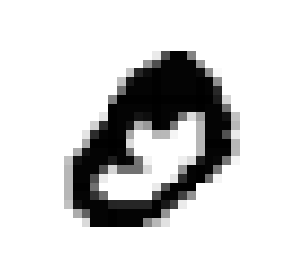

Saving figure some_digit_plot


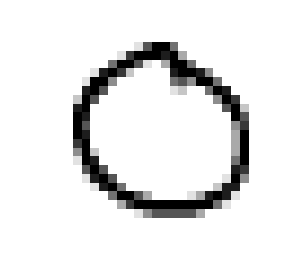

Saving figure some_digit_plot


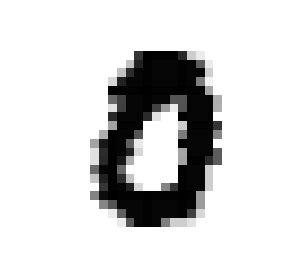

Saving figure some_digit_plot


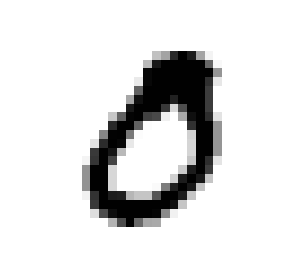

Saving figure some_digit_plot


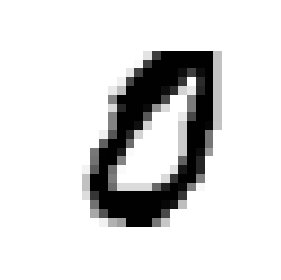

Saving figure some_digit_plot


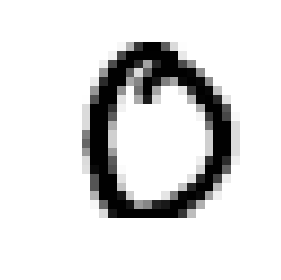

In [13]:
for i in range(12):
    some_digit = X[i]
    some_digit_image = some_digit.reshape(28, 28)
    plt.imshow(some_digit_image, cmap = mpl.cm.binary,
           interpolation="nearest")
    plt.axis("off")

    save_fig("some_digit_plot")
    plt.show()
    y[i]

In [14]:
def plot_digit(data):
    image = data.reshape(28, 28)
    plt.imshow(image, cmap = mpl.cm.binary,
               interpolation="nearest")
    plt.axis("off")

In [15]:
# EXTRA
def plot_digits(instances, images_per_row=10, **options):
    size = 28
    images_per_row = min(len(instances), images_per_row)
    images = [instance.reshape(size,size) for instance in instances]
    n_rows = (len(instances) - 1) // images_per_row + 1
    row_images = []
    n_empty = n_rows * images_per_row - len(instances)
    images.append(np.zeros((size, size * n_empty)))
    for row in range(n_rows):
        rimages = images[row * images_per_row : (row + 1) * images_per_row]
        row_images.append(np.concatenate(rimages, axis=1))
    image = np.concatenate(row_images, axis=0)
    plt.imshow(image, cmap = mpl.cm.binary, **options)
    plt.axis("off")

Saving figure more_digits_plot


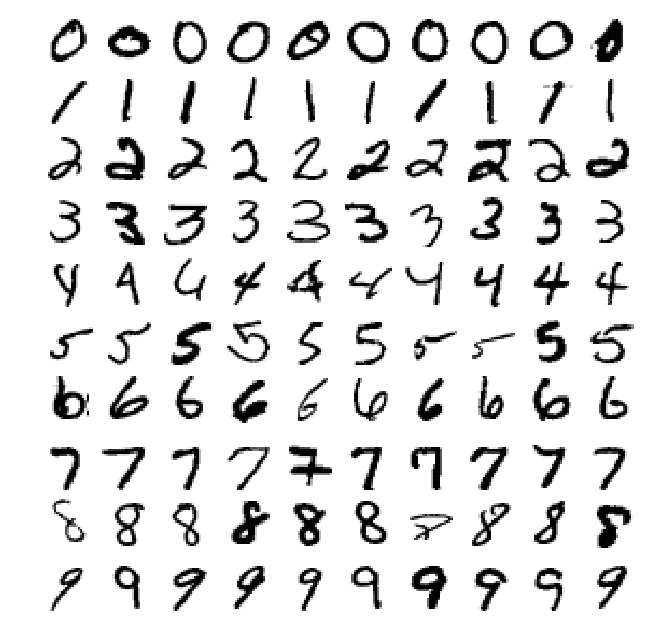

In [16]:
plt.figure(figsize=(9,9))
example_images = np.r_[X[:12000:600], X[13000:30600:600], X[30600:60000:590]]
plot_digits(example_images, images_per_row=10)
save_fig("more_digits_plot")
plt.show()

In [17]:
y[36000]

5

In [18]:
y[:10]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=int8)

In [19]:
# make our training/test splits
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

In [20]:
pd.Series(y_train).value_counts()

1    6742
7    6265
3    6131
2    5958
9    5949
0    5923
6    5918
8    5851
4    5842
5    5421
dtype: int64

In [21]:
y_train[5920:5930]

array([0, 0, 0, 1, 1, 1, 1, 1, 1, 1], dtype=int8)

In [22]:
pd.Series(y_test).value_counts()

1    1135
2    1032
7    1028
3    1010
9    1009
4     982
0     980
8     974
6     958
5     892
dtype: int64

In [23]:
y_test[975:985]

array([0, 0, 0, 0, 0, 1, 1, 1, 1, 1], dtype=int8)

# Binary classifier

In [24]:
y_train_5 = (y_train == 5)
y_test_5 = (y_test == 5)

In [25]:
y_test_5[:10]

array([False, False, False, False, False, False, False, False, False,
       False])

A good place to start is with a Stochastic Gradient Descent (SGD) classifier, using Scikit-Learn’s SGDClassifier class. This classifier has the advantage of being capable of handling very large datasets efficiently. This is in part because SGD deals with training instances independently, one at a time.

**Note**: a few hyperparameters will have a different default value in future versions of Scikit-Learn, so a warning is issued if you do not set them explicitly. This is why we set `max_iter=5` and `tol=-np.infty`, to get the same results as in the book, while avoiding the warnings.

In [26]:
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(max_iter=5, tol=-np.infty, random_state=42)
sgd_clf.fit(X_train, y_train_5)

SGDClassifier(alpha=0.0001, average=False, class_weight=None,
       early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
       l1_ratio=0.15, learning_rate='optimal', loss='hinge', max_iter=5,
       n_iter=None, n_iter_no_change=5, n_jobs=None, penalty='l2',
       power_t=0.5, random_state=42, shuffle=True, tol=-inf,
       validation_fraction=0.1, verbose=0, warm_start=False)

(-0.5, 27.5, 27.5, -0.5)

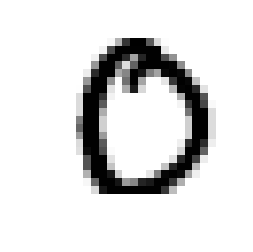

In [27]:
some_digit_image = some_digit.reshape(28, 28)
plt.imshow(some_digit_image, cmap = mpl.cm.binary,
           interpolation="nearest")
plt.axis("off")

In [28]:
sgd_clf.predict([some_digit])

array([False])

(-0.5, 27.5, 27.5, -0.5)

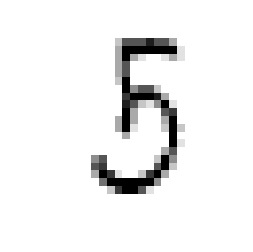

In [29]:
some_digit = X_train[33700]
some_digit_image = some_digit.reshape(28, 28)
plt.imshow(some_digit_image, cmap = mpl.cm.binary,
           interpolation="nearest")
plt.axis("off")

In [30]:
sgd_clf.predict([some_digit])

array([ True])

In [31]:
from sklearn.model_selection import cross_val_score
cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.869  , 0.83725, 0.90535])

In [32]:
# we can implement a stratified k-fold classifier ourselves
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone

skfolds = StratifiedKFold(n_splits=3, random_state=42)

for train_index, test_index in skfolds.split(X_train, y_train_5):
    clone_clf = clone(sgd_clf)
    X_train_folds = X_train[train_index]
    y_train_folds = (y_train_5[train_index])
    X_test_fold = X_train[test_index]
    y_test_fold = (y_train_5[test_index])

    clone_clf.fit(X_train_folds, y_train_folds)
    y_pred = clone_clf.predict(X_test_fold)
    n_correct = sum(y_pred == y_test_fold)
    print(n_correct / len(y_pred))

0.869
0.83725
0.90535


This demonstrates why accuracy is generally not the preferred performance measure for classifiers, especially when you are dealing with skewed datasets.

In [33]:
np.zeros((2, 1), dtype=bool)

array([[False],
       [False]])

In [34]:
# build a classifier that predicts every image as not 5
from sklearn.base import BaseEstimator
class Never5Classifier(BaseEstimator):
    def fit(self, X, y=None):
        pass
    def predict(self, X):
        return np.zeros((len(X), 1), dtype=bool)

In [35]:
never_5_clf = Never5Classifier()
cross_val_score(never_5_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([1.     , 0.72895, 1.     ])

Just like the cross_val_score() function, cross_val_predict() performs K-fold cross-validation, but instead of 
returning the evaluation scores, it returns the predictions made on each test fold.

In [36]:
from sklearn.model_selection import cross_val_predict

y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)

Each row in a confusion matrix represents an actual class, while each column represents a predicted class. 

In [37]:
# True Netagive  |  False Positive
# False Negative |  True Positive
from sklearn.metrics import confusion_matrix

confusion_matrix(y_train_5, y_train_pred)

array([[47700,  6879],
       [  889,  4532]])

In [38]:
y_train_perfect_predictions = y_train_5

In [39]:
confusion_matrix(y_train_5, y_train_perfect_predictions)

array([[54579,     0],
       [    0,  5421]])

In [40]:
from sklearn.metrics import precision_score, recall_score

precision_score(y_train_5, y_train_pred)

0.3971606344755061

$$precision = \frac{TP}{(TP+FP)}$$

In [41]:
4532 / (4532 + 6879)

0.3971606344755061

$$recall = \frac{TP}{(TP+FN)}$$

In [42]:
recall_score(y_train_5, y_train_pred)

0.8360081165836561

In [43]:
4532 / (4532 + 889)

0.8360081165836561

![Precision & Recall](PR.png)

$$F1 = \frac{2}{\frac{1}{precision}+\frac{1}{recall}}$$

In [44]:
from sklearn.metrics import f1_score
f1_score(y_train_5, y_train_pred)

0.5384980988593155

## End of Session ##

To understand the Precision/Recall tradeoff, let’s look at how the SGDClassifier makes its classification decisions. For each instance, it computes a score based on a decision function, and if that score is greater than a threshold, it assigns the instance to the positive class, or else it assigns it to the negative class.

![Precision & Recall](PRscore.png)

In [45]:
y_scores = sgd_clf.decision_function([some_digit])
y_scores

array([66313.57581278])

In [46]:
threshold = 0
y_some_digit_pred = (y_scores > threshold)

In [47]:
y_some_digit_pred

array([ True])

In [48]:
threshold = 200000
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([False])

In [49]:
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3,
                             method="decision_function")

In [50]:
from sklearn.metrics import precision_recall_curve

precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

In [51]:
len(thresholds)

59868

Saving figure precision_recall_vs_threshold_plot


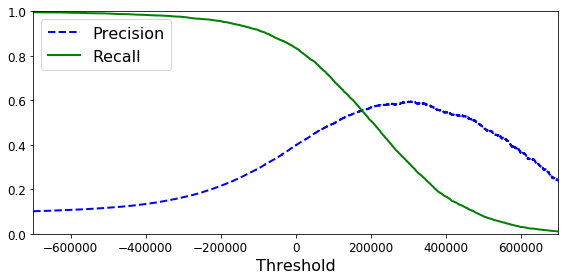

In [52]:
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision", linewidth=2)
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall", linewidth=2)
    plt.xlabel("Threshold", fontsize=16)
    plt.legend(loc="upper left", fontsize=16)
    plt.ylim([0, 1])

plt.figure(figsize=(8, 4))
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.xlim([-700000, 700000])
save_fig("precision_recall_vs_threshold_plot")
plt.show()

Saving figure precision_vs_recall_plot


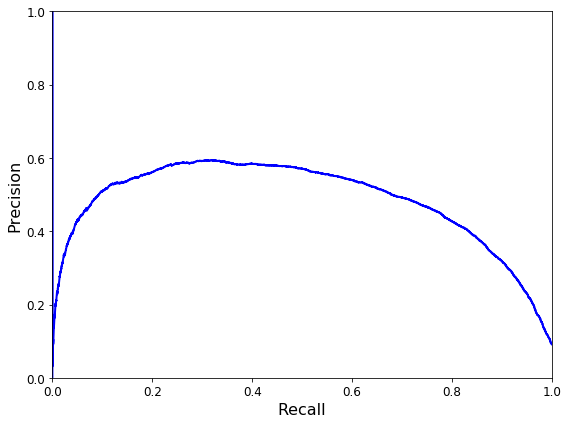

In [53]:
def plot_precision_vs_recall(precisions, recalls):
    plt.plot(recalls, precisions, "b-", linewidth=2)
    plt.xlabel("Recall", fontsize=16)
    plt.ylabel("Precision", fontsize=16)
    plt.axis([0, 1, 0, 1])

plt.figure(figsize=(8, 6))
plot_precision_vs_recall(precisions, recalls)
save_fig("precision_vs_recall_plot")
plt.show()

In [54]:
precisions[-10:]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 1.])

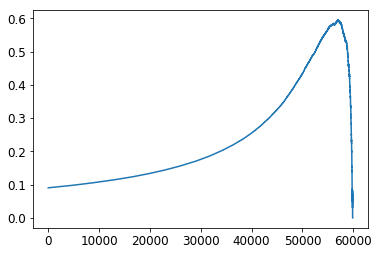

In [55]:
plt.plot(precisions[:-1])

# ROC curves

The **receiver operating characteristic (ROC)** curve is another common tool used with binary classifiers. It is very similar to the precision/recall curve, but instead of plotting precision versus recall, the ROC curve plots the true positive rate (another name for recall) against the false positive rate. The FPR is the ratio of negative instances that are incorrectly classified as positive. It is equal to one minus the true negative rate, which is the ratio of negative instances that are correctly classified as negative. The TNR is also called **specificity**. Hence the ROC curve plots sensitivity (recall) versus 1 – specificity.

In [56]:
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)

In [57]:
fpr[:10]

array([0.00000000e+00, 1.83220653e-05, 2.01542718e-04, 2.01542718e-04,
       5.86306088e-04, 5.86306088e-04, 6.96238480e-04, 6.96238480e-04,
       1.08100185e-03, 1.08100185e-03])

In [58]:
tpr[:10]

array([0.        , 0.        , 0.        , 0.00018447, 0.00018447,
       0.00036894, 0.00036894, 0.0005534 , 0.0005534 , 0.00073787])

Saving figure roc_curve_plot


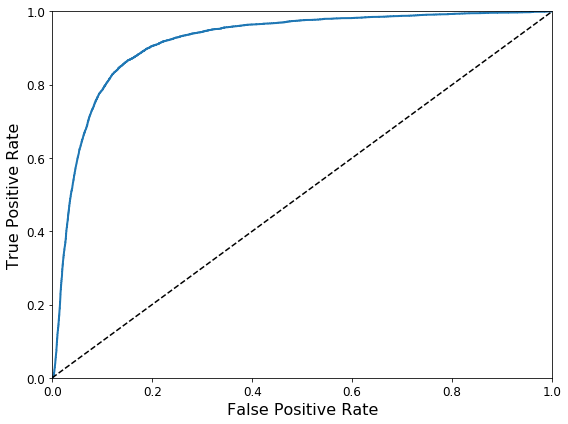

In [59]:
def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.axis([0, 1, 0, 1])
    plt.xlabel('False Positive Rate', fontsize=16)
    plt.ylabel('True Positive Rate', fontsize=16)

plt.figure(figsize=(8, 6))
plot_roc_curve(fpr, tpr)
save_fig("roc_curve_plot")
plt.show()

In [60]:
from sklearn.metrics import roc_auc_score

roc_auc_score(y_train_5, y_scores)

0.917402257366992

Since the ROC curve is so similar to the precision/recall (or PR) curve, you may wonder how to decide which one to use. As a rule of thumb, you should prefer the PR curve whenever the positive class is rare or when you care more about the false positives than the false negatives, and the ROC curve otherwise. 

**Note**: we set `n_estimators=10` to avoid a warning about the fact that its default value will be set to 100 in Scikit-Learn 0.22.

In [61]:
from sklearn.ensemble import RandomForestClassifier
forest_clf = RandomForestClassifier(n_estimators=10, random_state=42)
y_probas_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3,
                                    method="predict_proba")

In [62]:
# probability that the instance is not 5, or is a 5
y_probas_forest[:10]

array([[0.8, 0.2],
       [0.7, 0.3],
       [0.7, 0.3],
       [1. , 0. ],
       [0.2, 0.8],
       [0.9, 0.1],
       [0.8, 0.2],
       [0.7, 0.3],
       [0.6, 0.4],
       [0.9, 0.1]])

In [63]:
y_scores_forest = y_probas_forest[:, 1] # score = proba of positive class
fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_train_5, y_scores_forest)

Saving figure roc_curve_comparison_plot


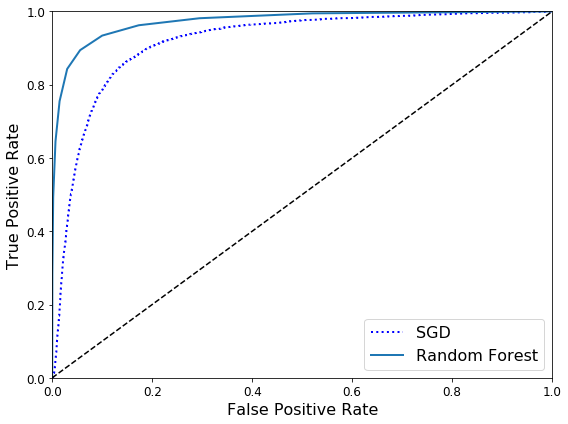

In [64]:
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, "b:", linewidth=2, label="SGD")
plot_roc_curve(fpr_forest, tpr_forest, "Random Forest")
plt.legend(loc="lower right", fontsize=16)
save_fig("roc_curve_comparison_plot")
plt.show()

In [65]:
roc_auc_score(y_train_5, y_scores_forest)

0.9727987276449468

In [66]:
y_train_pred_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3)
precision_score(y_train_5, y_train_pred_forest)

0.73638414437641

In [67]:
recall_score(y_train_5, y_train_pred_forest)

0.8430178933776056

## End of Session ##

# Multiclass classification

Some algorithms (such as Random Forest classifiers or naive Bayes classifiers) are capable of handling multiple classes directly. Others (such as Support Vector Machine classifiers or Linear classifiers) are strictly binary classifiers.

In [68]:
sgd_clf.fit(X_train, y_train)
sgd_clf.predict([some_digit])

array([8], dtype=int8)

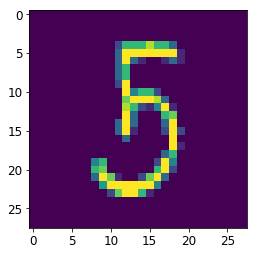

In [78]:
plt.imshow(some_digit.reshape(28,28))

In [69]:
some_digit_scores = sgd_clf.decision_function([some_digit])
some_digit_scores

array([[-179455.6282977 , -175462.11346853, -160840.17262355,
          17537.75504278, -295766.21868054,   66313.57581278,
        -284596.78183265, -461918.93924405,   86860.02278187,
        -616881.03220419]])

In [72]:
d = np.argmax(some_digit_scores)
d

8

In [73]:
sgd_clf.classes_

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=int8)

In [74]:
sgd_clf.classes_[d]

8

In [79]:
%%time
from sklearn.multiclass import OneVsOneClassifier
ovo_clf = OneVsOneClassifier(SGDClassifier(max_iter=5, tol=-np.infty, random_state=42))
ovo_clf.fit(X_train, y_train)
ovo_clf.predict([some_digit])

array([3], dtype=int8)

In [80]:
len(ovo_clf.estimators_)

45

In [81]:
%%time
forest_clf.fit(X_train, y_train)
forest_clf.predict([some_digit])

array([5], dtype=int8)

In [84]:
s = forest_clf.predict_proba([some_digit])
s

array([[0. , 0. , 0. , 0.3, 0. , 0.7, 0. , 0. , 0. , 0. ]])

In [85]:
np.argmax(s)

5

In [87]:
%%time
cross_val_score(sgd_clf, X_train, y_train, cv=3, scoring="accuracy")

CPU times: user 9.94 s, sys: 1.23 s, total: 11.2 s
Wall time: 11 s


array([0.86157768, 0.86489324, 0.87918188])

In [90]:
%%time
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.astype(np.float64))

CPU times: user 1.72 s, sys: 1 s, total: 2.72 s
Wall time: 1.46 s


In [91]:
cross_val_score(sgd_clf, X_train_scaled, y_train, cv=3, scoring="accuracy")

array([0.9070186 , 0.90659533, 0.91193679])

## Error Analysis ##

In [92]:
y_train_pred = cross_val_predict(sgd_clf, X_train_scaled, y_train, cv=3)
conf_mx = confusion_matrix(y_train, y_train_pred)
conf_mx

array([[5718,    2,   26,    9,   10,   52,   46,   10,   46,    4],
       [   1, 6446,   48,   29,    7,   43,    6,   14,  136,   12],
       [  55,   40, 5301,  105,   80,   31,   92,   59,  179,   16],
       [  42,   41,  142, 5309,    3,  261,   34,   51,  138,  110],
       [  17,   22,   37,    9, 5368,    9,   56,   32,   83,  209],
       [  71,   37,   37,  176,   79, 4631,  103,   24,  158,  105],
       [  28,   21,   44,    2,   46,   94, 5632,    5,   45,    1],
       [  26,   18,   72,   30,   58,   12,    4, 5782,   17,  246],
       [  44,  152,   67,  142,   20,  170,   49,   27, 5026,  154],
       [  39,   30,   27,   89,  158,   31,    2,  199,   76, 5298]])

In [95]:
def plot_confusion_matrix(matrix):
    """If you prefer color and a colorbar"""
    fig = plt.figure(figsize=(8,8))
    ax = fig.add_subplot(111)
    cax = ax.matshow(matrix)
    fig.colorbar(cax)

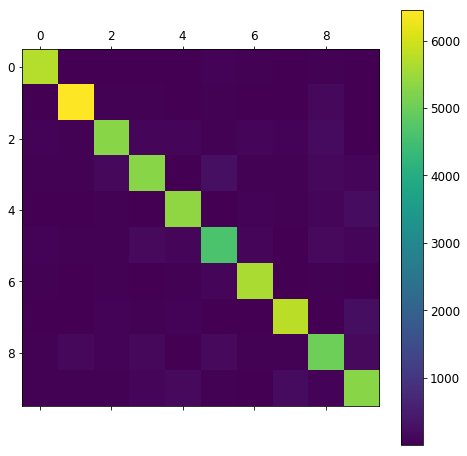

In [96]:
plot_confusion_matrix(conf_mx)

Saving figure confusion_matrix_plot


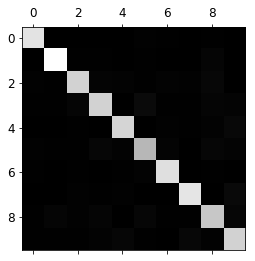

In [97]:
plt.matshow(conf_mx, cmap=plt.cm.gray)
save_fig("confusion_matrix_plot", tight_layout=False)
plt.show()

In [98]:
row_sums = conf_mx.sum(axis=1, keepdims=True)
norm_conf_mx = conf_mx / row_sums

Saving figure confusion_matrix_errors_plot


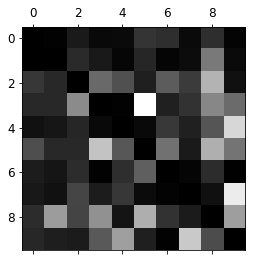

In [99]:
np.fill_diagonal(norm_conf_mx, 0)
plt.matshow(norm_conf_mx, cmap=plt.cm.gray)
save_fig("confusion_matrix_errors_plot", tight_layout=False)
plt.show()

Saving figure error_analysis_digits_plot


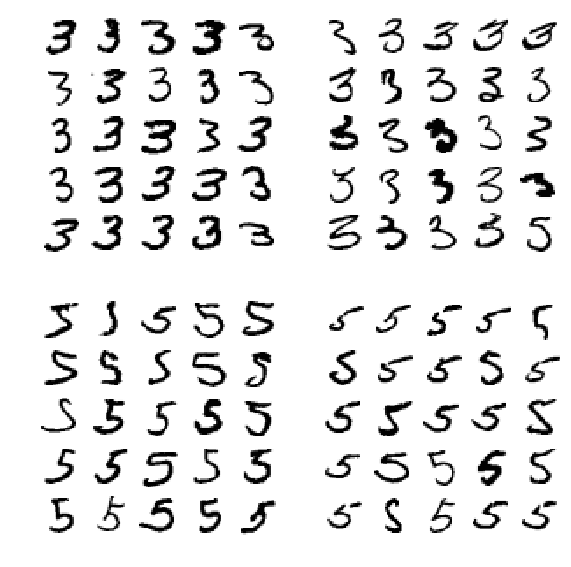

In [100]:
cl_a, cl_b = 3, 5
X_aa = X_train[(y_train == cl_a) & (y_train_pred == cl_a)]
X_ab = X_train[(y_train == cl_a) & (y_train_pred == cl_b)]
X_ba = X_train[(y_train == cl_b) & (y_train_pred == cl_a)]
X_bb = X_train[(y_train == cl_b) & (y_train_pred == cl_b)]

plt.figure(figsize=(8,8))
plt.subplot(221); plot_digits(X_aa[:25], images_per_row=5)
plt.subplot(222); plot_digits(X_ab[:25], images_per_row=5)
plt.subplot(223); plot_digits(X_ba[:25], images_per_row=5)
plt.subplot(224); plot_digits(X_bb[:25], images_per_row=5)
save_fig("error_analysis_digits_plot")
plt.show()

# Multilabel classification

A classification system that outputs multiple binary tags is called a multilabel classification system.

In [101]:
from sklearn.neighbors import KNeighborsClassifier

y_train_large = (y_train >= 7)
y_train_odd = (y_train % 2 == 1)
y_multilabel = np.c_[y_train_large, y_train_odd]

knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train, y_multilabel)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=5, p=2,
           weights='uniform')

In [102]:
knn_clf.predict([some_digit])

array([[False,  True]])

**Warning**: the following cell may take a very long time (possibly hours depending on your hardware).

In [ ]:
%%time
y_train_knn_pred = cross_val_predict(knn_clf, X_train, y_multilabel, cv=3, n_jobs=-1)
f1_score(y_multilabel, y_train_knn_pred, average="macro")

# Multioutput classification

In [107]:
a = np.random.randint(0, 100, (2, 784))
len(a)

2

In [108]:
noise = np.random.randint(0, 100, (len(X_train), 784))
X_train_mod = X_train + noise
noise = np.random.randint(0, 100, (len(X_test), 784))
X_test_mod = X_test + noise
y_train_mod = X_train
y_test_mod = X_test

Saving figure noisy_digit_example_plot


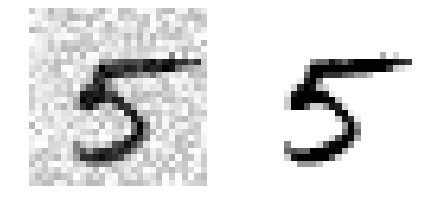

In [109]:
some_index = 5500
plt.subplot(121); plot_digit(X_test_mod[some_index])
plt.subplot(122); plot_digit(y_test_mod[some_index])
save_fig("noisy_digit_example_plot")
plt.show()

Saving figure cleaned_digit_example_plot


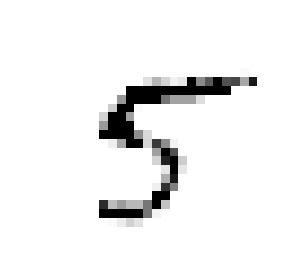

In [110]:
knn_clf.fit(X_train_mod, y_train_mod)
clean_digit = knn_clf.predict([X_test_mod[some_index]])
plot_digit(clean_digit)
save_fig("cleaned_digit_example_plot")

In [112]:
clean_digit.shape

(1, 784)